# Coding Project 1 : Linear Regression and Regularization

**Tristan Þórðarson**




---


*Note:* The provided structure for the code below is only suggestive, and if you want to structure your programs differently you may do so.

### Question 1 - Importing the Data

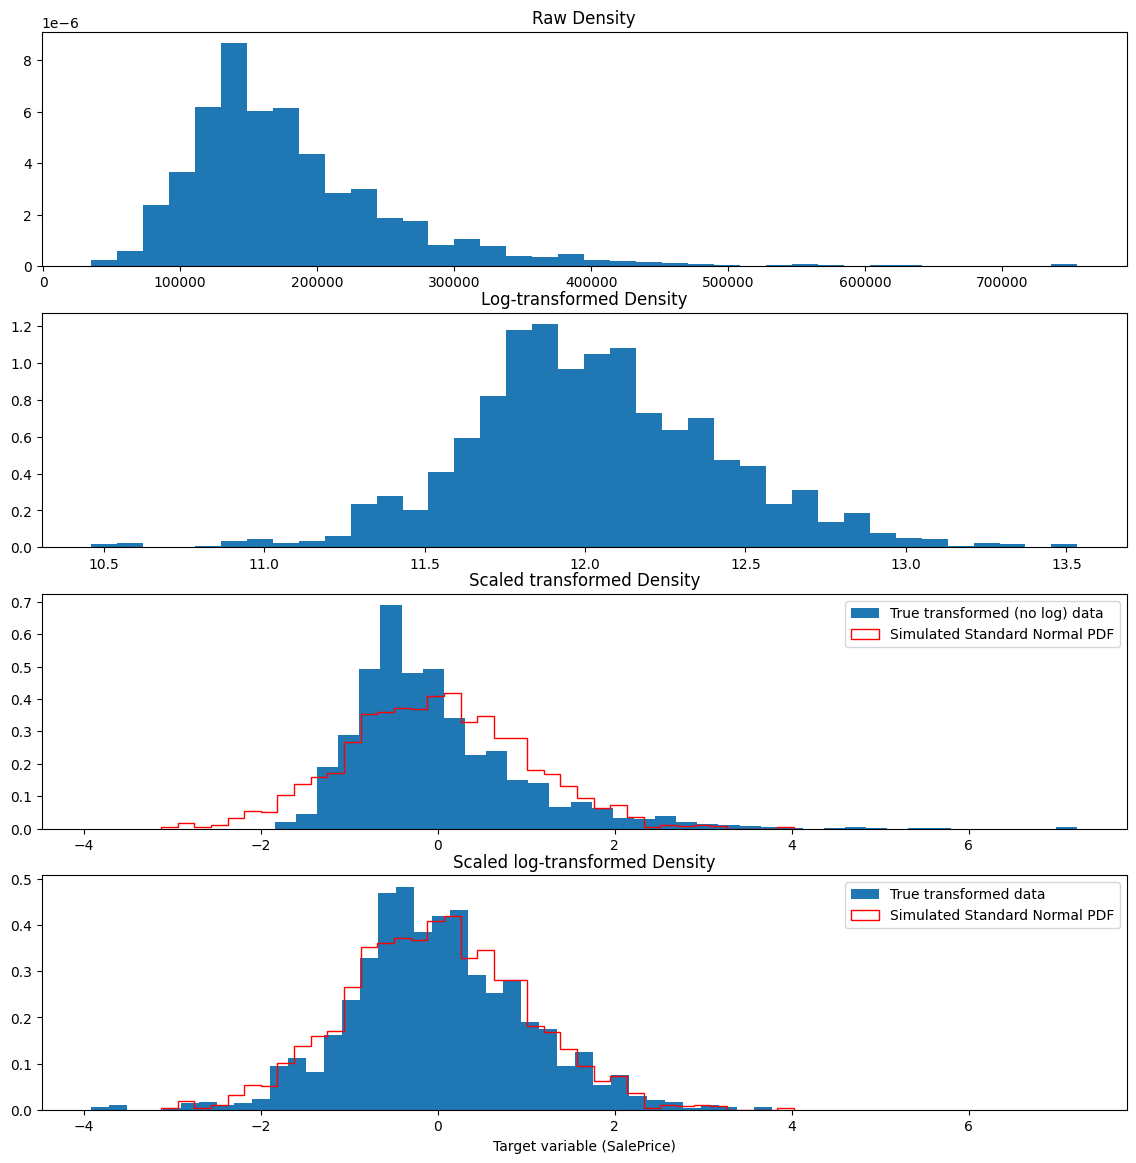

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection  import train_test_split

np.random.seed(16)

#1.a) Import the dataset Housing.csv into Python as a pandas DataFrame.
#To determine whether a variable is categorical or numerical, please refer to the file data_description.txt.
#Remember that the first column of the csv file is an index column and should not be considered as an explanatory variable.
data = pd.read_csv("Housing.csv")
data_keys = data.keys()
X = data[data_keys[1:-1]] # cutting col1: ID and last col (SalePrice)
y = data[data_keys[-1]]
n = len(y)
nbins = int(np.sqrt(n))

#1.b) Graphically determine whether the target variable SalePrice is approximately Gaussian.
fig, axs = plt.subplots(4,1,figsize=(14,14))
axs[0].hist(y,density=True,bins=nbins)
axs[0].set_title("Raw Density")

y_log = np.log(y)
axs[1].hist(y_log,density=True,bins=nbins)
axs[1].set_title("Log-transformed Density")

y_simulated = np.random.normal(size=n)

y_scaled = (y-y.mean())/y.std()
axs[2].hist(y_scaled,density=True,bins=nbins,label="True transformed (no log) data")
axs[2].set_title("Scaled transformed Density")
axs[2].hist(y_simulated,density=True,histtype='step',bins=nbins,color='red',label="Simulated Standard Normal PDF")
axs[2].legend()

y_trans = (y_log-y_log.mean())/y_log.std()
axs[3].hist(y_trans,density=True,bins=nbins,label="True transformed data")
axs[3].set_title("Scaled log-transformed Density")
axs[3].hist(y_simulated,density=True,histtype='step',bins=nbins,color='red',label="Simulated Standard Normal PDF")
axs[3].legend()

axs[2].sharex(axs[3])

plt.xlabel("Target variable (SalePrice)")
plt.show()


#If not, suggest a suitable transformation to bring SalePrice closer to a Gaussian distribution (logarithmic, inverse, square-root, ...).

#Do not forget to apply this transformation to the target variable SalePrice in the dataset.

#Why is it important to consider such potential transformations?


#1.c) Split the data into a training set (X,y)_train and a test set (X,y)_test.
#Randomly assign 70% of the observations to the training set and the remaining 30% to the test set.
data_train, data_test = train_test_split(data[data_keys[1:]],test_size=0.3)
X_train, X_test = data_train[data_keys[1:-1]], data_test[data_keys[1:-1]]
Y_train, Y_test = data_train[data_keys[-1]], data_test[data_keys[-1]]

#1.d) Replace missing values in X using the training data statistics only -> use .fillna(...)
#For numerical features, replace missing values with the mean of the column .
#For categorical features, replace missing values with the most frequent category.
#You can use the function df.select_dtypes(...) to idetify categorical variables as the variables with type 'object' and 'category'. 
#Some categorical variables admit NA (or None) as a valid category, which should be treated as an actual level and not as missing.

def map_feature_type():
    description_file = open("data_description.txt")
    lines = []
    general = []
    while True:
        content = description_file.readline()
        if content:
            general.append(content.split())
            if content[0] != " " and content[0] != "\n" and content[0] != "\t":
                info = content.split(" ",2)
                lines.append(info[:2])
        if not content:
            break
    description_file.close()

    type_map = {}
    na_map = {}
    for l in lines:
        type_map[l[0]] = l[1][:-1]
        na_map[l[0]] = 0

    keys = list(type_map.keys())
    
    i = -1
    for l in general:
        if l and l[0] in keys:
            i+=1
        if l and l[0] == "NA":
            na_map[keys[i]] = 1

    return type_map,na_map

type_map,na_map = map_feature_type()
categorical = []
for f,t in type_map.items():
    if t == "(numerical)":
        X_train.loc[:,f] = X_train[f].astype(float)
        X_test.loc[:,f] = X_test[f].astype(float)

        X_train.loc[:,f] = X_train[f].fillna(X_train[f].mean())
        X_test.loc[:,f] = X_test[f].fillna(X_train[f].mean())

        # After filling is done we standardize (should have little affect whether done before or after)
        X_test.loc[:,f] = (X_test[f]-X_train[f].mean())/X_train[f].std()  
        X_train.loc[:,f] = (X_train[f]-X_train[f].mean())/X_train[f].std()

    if t == "(categorical)":
        categorical.append(f)
        X_train.loc[:,f] = X_train[f].astype(str)
        X_test.loc[:,f] = X_test[f].astype(str)
  
        if na_map[f] == 0:
            X_train.loc[:,f] = X_train[f].fillna(X_train[f].value_counts().index[0])
            X_test.loc[:,f] = X_test[f].fillna(X_train[f].value_counts().index[0])

X_train_encoded = pd.get_dummies(X_train,categorical)
X_test_encoded = pd.get_dummies(X_test,categorical)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns,fill_value=0)

def display_features():
    for f,t in type_map.items():
        if t == "(numerical)":
            plt.hist(X_test[f])
            plt.title(f"{f}-{t}")
            plt.show()

        if t == "(categorical)":
            plt.hist(X_test[f])
            plt.title(f"{f}-{t}")
            plt.show()

# display_features()


#### 1b
The target value is $\textbf{not}$ approximately gaussian, the density is highly right-skewed and the values are rather large. As a standard solution we log-transform which dampers the scale and overcomes the skewness. Furthermore, as can be observed the values are not on a standard normal scale hence we standardize the log-values: $$y'=\frac{\ln(y)-\mu_{\ln(y)}}{\sigma_{\ln(y)}}$$ and now for "sufficiently many" observations the distribution of $y'$ is almost surely standard gaussian. 

But to answer the question, why do we need to transform the targets?
It's because most "simple" modelling frameworks assume gaussianity or standard gaussianity, and especially since we're working with ordinary linear regression where the noise term $\epsilon$ is assumed to have a zero mean and constant variance it's imported to transform the data on that scale.

### Question 2 - Linear Regression on Numerical Features

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

#2.a) Fit a linear regression model on the training dataset with numerical features only using the sklearn package.
#Output a table with the name of each feature and the associated regression coefficient.

#Compare the in-sample and out-of-sample Mean Squared Error (MSE) and R^2.


#2.b) (i) Compute the estimated coefficients for each explanatory variable using the numpy package. 
#Remember that the design matrix A needs to include a column of 1's. Use np.linalg.solve(...).

# (ii) Compute the standard error of each estimated coefficient using the numpy package.

# (iii) Compute the (in-sample) MSE and R^2 using the numpy package.

# (iv) Do the results change using pseudoinversion instead of standard matrix inversion? Use np.linalg.pinv(...).

# (v) Compare your results (with and without pseudoinversion) to the output of the sm.OLS(...) function.



### Question 3 - Regularization Techniques

In [3]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, RepeatedKFold, KFold

# 3.a) Linear regression with the full Housing dataset (numerical + categorical).
#How do the in-sample and out-of-sample metrics change when including categorical features, and what does this reveal about the model’s ability to generalize?


#3.b) Implement the Truncated Pseudoinverse, Ridge, Lasso, and Elastic Net regularization techniques.
#Use 8-fold cross-validation to tune the hyperparameters of each regularization technique based on the MSE metric.
#Why is it important that the intercept is not penalized in these models?

#Compare their performance in terms of in-sample and out-of-sample MSE and R2 with the linear regressions of Questions 2.a) and 3.a).


#3.c) During cross-validation, what are possible sources of information leakage? 
#Briefly describe what leakage means in this context, and explain what steps you would take to avoid it if you were building a more complete data preprocessing pipeline (e.g., with imputation, scaling, or encoding). 
#You do not need to implement these steps here, only to explain the idea.


#3.d) For the  Lasso and Elastic Net regressions, how many coefficients are non-zero?

#Compare this number with the number of coefficients retained by the Ridge and Truncated Pseudoinverse models and provide an explanation.


#3.e) #Based on your findings from Questions 2 and 3, which model would you recommend for predicting house prices? 
#Justify your choice not only by comparing performance metrics, but also by discussing the nature of the problem (e.g., number of features, presence of categorical variables, potential collinearity, sparsity, nonlinearity). 
#Explain how the strengths and limitations of the chosen method align with this problem structure.

